# Importing the required Libraries

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
base_path = r"D:/Work/Hackathon/AI_ML/Dev/Dataset/D_new/"
model_route = r"D:/Work/Hackathon/AI_ML/Dev/Models/"

In [3]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['TORCH_USE_CUDA_DSA'] = '1'

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
from tqdm.notebook import tqdm
import re
import numpy as np
import random


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

# Preparing Dataset

Using Amazon Books Reviews Dataset - [link](https://www.kaggle.com/datasets/mohamedbakhet/amazon-books-reviews)

In [3]:
books_details_file_path = base_path + "books_data.csv"
reviews_file_path = base_path + "Books_rating.csv"

In [4]:
# Load the reviews file
# Actual number of rows are of around 3000000
n = 3000000 - 1 #number of records in file (excludes header)
s = 400000 #desired sample size
skip = sorted(random.sample(range(1,n+1),n-s)) #the 0-indexed header will not be included in the skip list
reviews_df = pd.read_csv(reviews_file_path, skiprows=skip)

In [5]:
# Load the Books Details file
# Actual number of rows are of around 212404
n = 212404 - 1 #number of records in file (excludes header)
s = 150000 #desired sample size
skip = sorted(random.sample(range(1,n+1),n-s)) #the 0-indexed header will not be included in the skip list
# df = pd.read_csv(filename, skiprows=skip)
books_details_df = pd.read_csv(books_details_file_path, skiprows=skip)

In [6]:
books_details_df.head()

,Title,description,authors,image,previewLink,publisher,publishedDate,infoLink,categories,ratingsCount
0,Its Only Art If Its Well Hung!,NaN,['Julie Strain'],http://books.google.com/books/content?id=DykPA...,http://books.google.nl/books?id=DykPAAAACAAJ&d...,NaN,1996,http://books.google.nl/books?id=DykPAAAACAAJ&d...,['Comics & Graphic Novels'],NaN
1,Dr. Seuss: American Icon,Philip Nel takes a fascinating look into the k...,['Philip Nel'],http://books.google.com/books/content?id=IjvHQ...,http://books.google.nl/books?id=IjvHQsCn_pgC&p...,A&C Black,2005-01-01,http://books.google.nl/books?id=IjvHQsCn_pgC&d...,['Biography & Autobiography'],NaN
2,Wonderful Worship in Smaller Churches,This resource includes twelve principles in un...,['David R. Ray'],http://books.google.com/books/content?id=2tsDA...,http://books.google.nl/books?id=2tsDAAAACAAJ&d...,NaN,2000,http://books.google.nl/books?id=2tsDAAAACAAJ&d...,['Religion'],NaN
3,"Nation Dance: Religion, Identity and Cultural ...",NaN,['Edward Long'],NaN,http://books.google.nl/books?id=399SPgAACAAJ&d...,NaN,2003-03-01,http://books.google.nl/books?id=399SPgAACAAJ&d...,NaN,NaN
4,The Church of Christ: A Biblical Ecclesiology ...,In The Church of Christ: A Biblical Ecclesiolo...,['Everett Ferguson'],http://books.google.com/books/content?id=kVqRa...,http://books.google.nl/books?id=kVqRaiPlx88C&p...,Wm. B. Eerdmans Publishing,1996,http://books.google.nl/books?id=kVqRaiPlx88C&d...,['Religion'],5.0


In [7]:
reviews_df.head()

,Id,Title,Price,User_id,profileName,review/helpfulness,review/score,review/time,review/summary,review/text
0,0826414346,Dr. Seuss: American Icon,NaN,A2F6NONFUDB6UK,Malvin,2/2,4.0,1127174400,One of America's greatest creative talents,"""Dr. Seuss: American Icon"" by Philip Nel is a ..."
1,0829814000,Wonderful Worship in Smaller Churches,19.40,A3OQWLU31BU1Y,Maxwell Grant,1/1,5.0,1222560000,Small church pastor? This is the book on worship,I hadn't been a small church pastor very long ...
2,0595344550,Whispers of the Wicked Saints,10.95,AE5JROER4ERSO,carrie,0/0,5.0,1119484800,The truth about WOTWS,I have to say that my friends at work all read...
3,0595344550,Whispers of the Wicked Saints,10.95,A3U1XS6XK6YUU4,kassie,1/1,5.0,1115078400,You have to read this book,I can not talk this book up enough. It was wel...
4,0802841899,The Church of Christ: A Biblical Ecclesiology ...,25.97,ARI272XF8TOL4,Christopher J. Bray,74/81,5.0,955411200,Ecclesiological Milestone,With the publication of Everett Ferguson's boo...


In [8]:
# Explore the reviews dataset
print("Reviews Dataset:")
print(reviews_df.info())

# Explore the Books Details dataset
print("\nBooks Details Dataset:")
print(books_details_df.info())

Reviews Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400001 entries, 0 to 400000
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Id                  400001 non-null  object 
 1   Title               399969 non-null  object 
 2   Price               64114 non-null   float64
 3   User_id             325376 non-null  object 
 4   profileName         325358 non-null  object 
 5   review/helpfulness  400001 non-null  object 
 6   review/score        400001 non-null  float64
 7   review/time         400001 non-null  int64  
 8   review/summary      399939 non-null  object 
 9   review/text         400001 non-null  object 
dtypes: float64(2), int64(1), object(7)
memory usage: 30.5+ MB
None

Books Details Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150001 entries, 0 to 150000
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         ----

In [9]:
# Check for missing values in Reviews dataset
reviews_missing = reviews_df.isnull().sum()

# Check for missing values in Books Details dataset
books_missing = books_details_df.isnull().sum()

# Display missing values
print("Reviews Missing Values:")
print(reviews_missing)

print("\nBooks Details Missing Values:")
print(books_missing)

Reviews Missing Values:
Id                         0
Title                     32
Price                 335887
User_id                74625
profileName            74643
review/helpfulness         0
review/score               0
review/time                0
review/summary            62
review/text                0
dtype: int64

Books Details Missing Values:
Title                 1
description       48350
authors           22257
image             36795
previewLink       16842
publisher         53667
publishedDate     17882
infoLink          16842
categories        29132
ratingsCount     114837
dtype: int64


## Dealing with Missing Values

In [10]:
reviews_df.columns, books_details_df.columns

(Index(['Id', 'Title', 'Price', 'User_id', 'profileName', 'review/helpfulness',
        'review/score', 'review/time', 'review/summary', 'review/text'],
       dtype='object'),
 Index(['Title', 'description', 'authors', 'image', 'previewLink', 'publisher',
        'publishedDate', 'infoLink', 'categories', 'ratingsCount'],
       dtype='object'))

In [11]:
# Drop rows with missing 'Title' and 'User_id'
reviews_df = reviews_df.dropna(subset=['Title', 'User_id'])

# Drop 'profileName' column, we won't be using it
reviews_df = reviews_df.drop(columns=['profileName'])

In [12]:
# Drop 'Price' column, we won't be using it ---------------------------------------------------------------------------------------------------------------
# reviews_df = reviews_df.drop(columns=['Price'])

# Calculate the 25th and 75th percentiles
q25 = reviews_df['Price'].quantile(0.75)
q75 = reviews_df['Price'].quantile(0.90)

# Generate random values within the 25th and 75th percentile range
def fill_random_between_quartiles(series):
    random_values = np.random.uniform(q25, q75, series.isna().sum())
    series.loc[series.isna()] = random_values
    return series

# Fill the null values with random values between the 25th and 75th percentile
reviews_df['Price'] = fill_random_between_quartiles(reviews_df['Price'])

C:\Users\Sanat.Tudu\AppData\Local\Temp\ipykernel_22744\1250745246.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  series.loc[series.isna()] = random_values


In [13]:
# Fill missing values in 'review/summary' and 'review/text' with empty strings
# reviews_df['review/summary'] = reviews_df['review/summary'].fillna('')
# reviews_df['review/text'] = reviews_df['review/text'].fillna('')
# instead of filling with empty string we will drop

reviews_df = reviews_df.dropna()

# Display updated information about missing values
reviews_missing_values = reviews_df.isnull().sum()
print("Reviews Missing Values After Handling:")
print(reviews_missing_values)

Reviews Missing Values After Handling:
Id                    0
Title                 0
Price                 0
User_id               0
review/helpfulness    0
review/score          0
review/time           0
review/summary        0
review/text           0
dtype: int64


In [14]:
reviews_df.shape

(325284, 9)

In [15]:
reviews_df.Price

0         25.600963
1         19.400000
2         10.950000
3         10.950000
4         25.970000
            ...    
399994    31.098322
399995    30.163728
399996    26.119960
399997    36.527767
399999    31.023921
Name: Price, Length: 325284, dtype: float64

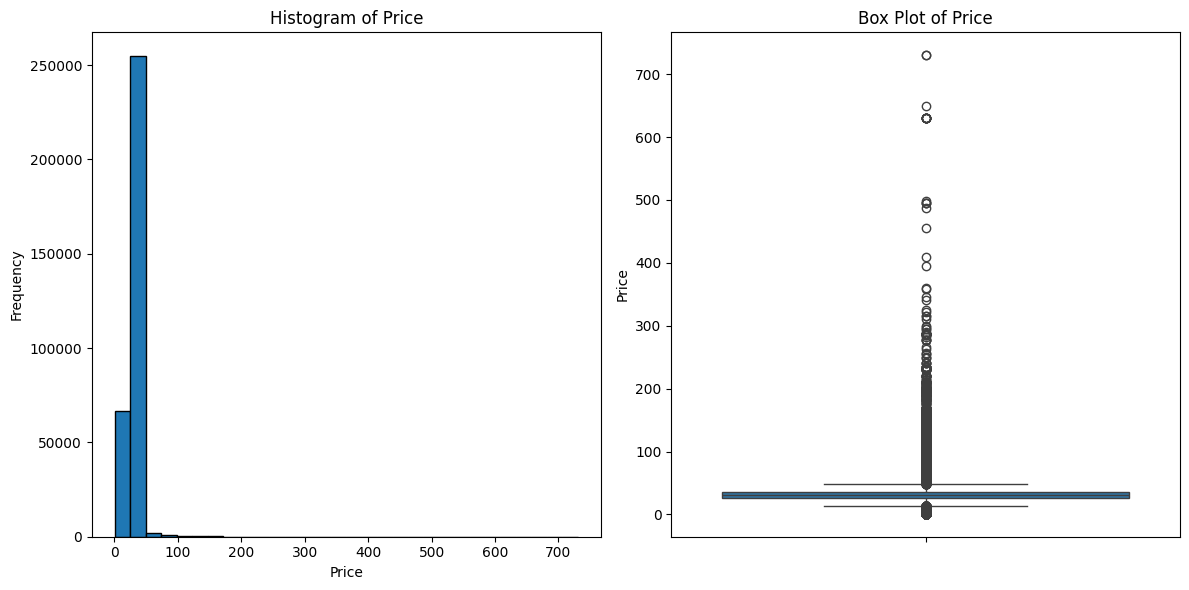

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))

# Histogram
plt.subplot(1, 2, 1)
plt.hist(reviews_df['Price'], bins=30, edgecolor='black')
plt.title('Histogram of Price')
plt.xlabel('Price')
plt.ylabel('Frequency')

# Box Plot
plt.subplot(1, 2, 2)
sns.boxplot(y=reviews_df['Price'])
plt.title('Box Plot of Price')

plt.tight_layout()
plt.show()


In [17]:
# Drop rows with missing 'Title'
books_details_df = books_details_df.dropna(subset=['Title'])

# Impute missing values in 'ratingsCount' with the median
books_details_df['ratingsCount'] = books_details_df['ratingsCount'].fillna(books_details_df['ratingsCount'].median())

# Fill missing values in textual columns with empty strings
textual_columns = ['description', 'authors', 'publisher', 'publishedDate', 'categories']
# books_details_df[textual_columns] = books_details_df[textual_columns].fillna('')
# instead of filling with empty strings we will drop those rows
books_details_df = books_details_df.dropna()

# Dropping columns we are not going to use ----------------------------------------------------------------------------------------------------------------
columns_to_drop = ['previewLink', 'infoLink']
books_details_df = books_details_df.drop(columns=columns_to_drop)
books_details_df = books_details_df.dropna() # to get rid of null images link

# Display updated information about missing values
books_details_missing_values = books_details_df.isnull().sum()
print("Books Details Missing Values After Handling:")
print(books_details_missing_values)


Books Details Missing Values After Handling:
Title            0
description      0
authors          0
image            0
publisher        0
publishedDate    0
categories       0
ratingsCount     0
dtype: int64


In [18]:
books_details_df.shape

(83241, 8)

## Merging Datasets

In [19]:
#Merge DataFrame or named Series objects with a database-style join.
#here i want to get all user id from left dataframe so, using left join
merged_df = pd.merge(reviews_df, books_details_df, on='Title', how='left')

In [20]:
#analyzing merged dataframe
merged_df_missing_values = merged_df.isnull().sum()
print("Merged Dataframe Missing Values:")
print(merged_df_missing_values)

Merged Dataframe Missing Values:
Id                         0
Title                      0
Price                      0
User_id                    0
review/helpfulness         0
review/score               0
review/time                0
review/summary             0
review/text                0
description           168020
authors               168020
image                 168020
publisher             168020
publishedDate         168020
categories            168020
ratingsCount          168020
dtype: int64


In [21]:
merged_df = merged_df.dropna()

In [22]:
merged_df.head()

,Id,Title,Price,User_id,review/helpfulness,review/score,review/time,review/summary,review/text,description,authors,image,publisher,publishedDate,categories,ratingsCount
0,0826414346,Dr. Seuss: American Icon,25.600963,A2F6NONFUDB6UK,2/2,4.0,1127174400,One of America's greatest creative talents,"""Dr. Seuss: American Icon"" by Philip Nel is a ...",Philip Nel takes a fascinating look into the k...,['Philip Nel'],http://books.google.com/books/content?id=IjvHQ...,A&C Black,2005-01-01,['Biography & Autobiography'],2.0
4,0802841899,The Church of Christ: A Biblical Ecclesiology ...,25.970000,ARI272XF8TOL4,74/81,5.0,955411200,Ecclesiological Milestone,With the publication of Everett Ferguson's boo...,In The Church of Christ: A Biblical Ecclesiolo...,['Everett Ferguson'],http://books.google.com/books/content?id=kVqRa...,Wm. B. Eerdmans Publishing,1996,['Religion'],5.0
5,0854968350,Muslim Women's Choices: Religious Belief and S...,27.034668,A2OP3N8OXCQEZB,6/8,5.0,1121385600,Excellent,This is an excellent book. It offers the opini...,Counters the Western views and stereotypes of ...,"['Camillia Fawzi El-Solh', 'Judy Mabro']",http://books.google.com/books/content?id=o7izA...,Berg Pub Limited,1994-02-17,['Religion'],2.0
13,0517150328,History of Magic and the Occult,31.038181,A37QRFQTGTJH7K,6/6,4.0,1073606400,Informative but dry...,"I have the older version of the book, but I un...","See the history of witchcraft, magic and super...",['DK'],http://books.google.com/books/content?id=PSnkD...,Dorling Kindersley Ltd,2020-08-06,"['Body, Mind & Spirit']",2.0
14,158322047X,The Forbidden Stories of Marta Veneranda,21.950000,A2NI0TUDXKM2FP,1/1,5.0,1106524800,"The Little Book that Could, and Did.",An incredible collection of stories that will ...,"Marta Veneranda, a Latina neoyorkina, finds th...",['Sonia Rivera-Valdes'],http://books.google.com/books/content?id=A7aYb...,Seven Stories Press,2001-03-06,['Fiction'],2.0


In [23]:
merged_df.shape

(157264, 16)

In [24]:
# Reset the index
merged_df.reset_index(drop=True, inplace=True)

# Importing Sentiment Analysis Model
Trained in previous notebook- [kaggle notebook](https://www.kaggle.com/code/anshkgoyal/sentiment-analysis-model/edit)

In [26]:
model_path = model_route + 'sentiment_model.pth'

class SentimentModel(nn.Module):
    def __init__(self, input_size, hidden_size=32,dropout_rate=0.4):
        super().__init__()
        self.sequential = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout_rate), #Dropout is a regularization technique commonly used in neural networks during training to prevent overfitting
            nn.Linear(hidden_size, hidden_size*2), #  linear layer (y=mx+c)
            nn.ReLU(), # max(0,x) , basically adds non-linearity
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size*2, hidden_size*4),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size*4, hidden_size*8),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size*8, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.sequential(x)


# Load the entire model
sentiment_model=torch.load(model_path)
sentiment_model.to(device)

SentimentModel(
  (sequential): Sequential(
    (0): Linear(in_features=12000, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=32, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.4, inplace=False)
    (6): Linear(in_features=64, out_features=128, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.4, inplace=False)
    (9): Linear(in_features=128, out_features=256, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.4, inplace=False)
    (12): Linear(in_features=256, out_features=1, bias=True)
    (13): Sigmoid()
  )
)

## Preprocessing Text
Processing sentiment analysis in batches using PyTorch's DataLoader, the code assigns sentiment scores to a DataFrame (merged_df) by making predictions based on the 'review/text' column. Each batch of text is preprocessed, tokenized, and converted into a dense tensor for inference, and the resulting sentiment scores are added to the corresponding rows in the DataFrame.


>Countvectorizer stores vocabulary(basically list of words) as a sparse matrix which only stores non-zero elements along with their positions(index value)
>
>When a sparse matrix is converted to a dense matrix (ND array), it becomes memory intensive because all the zero values in the sparse matrix, which were not stored due to their sparsity, need to be explicitly represented in the dense matrix.
>
>In a sparse matrix, only the non-zero elements are stored along with their positions. So, if you have a large matrix where most of the elements are zero, a sparse matrix representation will save a lot of memory. But when you convert this sparse matrix to a dense matrix, you need to allocate memory for all elements of the matrix, including the zeros. This leads to a significant increase in memory usage
>
>sparse matrices can be considered as a form of Embeddings, particularly in the context of representing high-dimensional and sparse data.Embeddings make it easier to do machine learning on large inputs like sparse vectors representing words. Ideally, an embedding captures some of the semantics of the input by placing semantically similar inputs close together in the embedding space. An embedding can be learned and reused across models.

Sparse Matrices Example:

>(0, 0) -> 1
>
>(0, 2) -> 2
>
>(0, 4) -> 1
>
>(1, 1) -> 1
>
>(1, 3) -> 1
>
>(2, 0) -> 1
>
>(2, 1) -> 1

Dense Matrices Example:

|      | "cat" | "dog" | "apple" | "banana" | "orange" |
|------|-------|-------|---------|----------|----------|
| Doc1 |   1   |   0   |    2    |    0     |    1     |
| Doc2 |   0   |   1   |    0    |    1     |    0     |
| Doc3 |   1   |   1   |    0    |    0     |    0     |



The basic dataset class in PyTorch is often used for handling custom datasets. It requires you to override the `__len__` and `__getitem__` methods. This class is suitable for scenarios where your data can be loaded on-the-fly or is not stored in memory as tensors.

- `__init__`: Initializes the dataset with the texts to be analyzed, the vectorizer used to convert text into numerical vectors, the sentiment model used for scoring, and the device on which computations should be performed.
- `__len__`: Returns the number of texts in the dataset.
- `__getitem__`: Retrieves a particular item from the dataset. This function also performs preprocessing on the text, including converting to lowercase, removing HTML line breaks, removing special characters, tokenizing the text, removing non-alphabetic tokens, and removing English stopwords. The processed text is then transformed into a numerical vector using the provided vectorizer and passed through the sentiment model to generate a sentiment score. The score is returned as a PyTorch tensor and moved to the specified device.

When you convert a sparse matrix to a dense tensor using torch.tensor(vectorized_text.toarray(), dtype=torch.float32), you are indeed creating a dense representation of the data. In theory, increasing the batch size would lead to more data being loaded into memory, potentially increasing memory consumption. However, PyTorch has optimizations to handle this more efficiently.

PyTorch's memory management is designed to optimize GPU usage, and it often performs operations in-place or uses memory pooling to minimize unnecessary memory allocations. When you use the DataLoader to load batches, PyTorch handles the memory allocation and deallocation efficiently.

In [27]:
from torchtext.data.utils import get_tokenizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
import joblib
import re
import nltk
nltk.download('stopwords')

class SentimentAnalysisDataset(torch.utils.data.Dataset):
    def __init__(self, texts, vectorizer, sentiment_model, device):
        """
        A dataset for sentiment analysis.

        Args:
            texts (list): List of text reviews.
            vectorizer: The vectorizer used during training.
            sentiment_model: The trained sentiment analysis model.
            device: The device (CPU/GPU) to which the tensor should be sent.
        """
        self.texts = texts
        self.vectorizer = vectorizer
        self.sentiment_model = sentiment_model
        self.device = device

    def __len__(self):
        """
        Returns the total number of samples in the dataset.

        Returns:
            int: The number of samples in the dataset.
        """
        return len(self.texts)

    def __getitem__(self, idx):
        """
        Retrieves and processes a single sample from the dataset.

        Args:
            idx (int): Index of the sample to retrieve.

        Returns:
            torch.Tensor: The sentiment score for the input text.
        """
        text = self.texts[idx]
        text = text.lower() # Convert to lowercase
        text = re.sub(r'<br\s*/*\s*><br\s*/*\s*>', '', text)
        text = re.sub(r"[^a-zA-Z0-9]", " ", text) # Remove special characters
        tokenizer = get_tokenizer("basic_english")
        tokens = tokenizer(text) # Tokenization
        tokens = [word for word in tokens if word.isalpha()] # Remove non-alphabetic tokens
        stop_words = set(stopwords.words("english")) - {'not'}
        tokens = [word for word in tokens if word not in stop_words] # Remove stopwords

        # Use the same vectorizer used during training
        vectorized_text = self.vectorizer.transform([" ".join(tokens)])
        tensor = torch.tensor(vectorized_text.toarray(), dtype=torch.float32)
        tensor = tensor.to(self.device)

        with torch.inference_mode():
            score = self.sentiment_model(tensor)
        return score

# Load the vectorizer
vectorizer = joblib.load(model_route + 'vectorizer.pkl')

# Batch size for processing
batch_size = 10000

dataset = SentimentAnalysisDataset(merged_df["review/text"], vectorizer, sentiment_model, device)
loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)

if 'sentiment_score' not in merged_df.columns:
    merged_df['sentiment_score'] = None

# __getitem__ is automatically(implicitely) called when using for loops
for i, scores in tqdm(enumerate(loader), total=len(loader), desc="Processing Reviews"):
    start = i * batch_size
    for j, score in enumerate(scores):
        score = score.item()
        merged_df.at[start+j, 'sentiment_score'] = score

d:\Work\Hackathon\AI_ML\Dev\.venv\Lib\site-packages\torchtext\data\__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Sanat.Tudu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
d:\Work\Hackathon\AI_ML\Dev\.venv\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator CountVectorizer from version 1.2.2 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warning

Processing Reviews:   0%|          | 0/16 [00:00<?, ?it/s]

In [ ]:
'''
#class SentimentAnalysisDataset method is much better which is using dataloader instead of generator
#so i will comment this previous method

from torchtext.data.utils import get_tokenizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
import joblib
import re



def preprocess_and_predict(texts, vectorizer, sentiment_model, device):
    for text in texts:
        text = text.lower() # Convert to lowercase
        text = re.sub(r'<br\s*/*\s*><br\s*/*\s*>', '', text)
        text = re.sub(r"[^a-zA-Z0-9]", " ", text) # Remove special characters
        tokenizer = get_tokenizer("basic_english")
        tokens = tokenizer(text) # Tokenization
        tokens = [word for word in tokens if word.isalpha()] # Remove non-alphabetic tokens
        stop_words = set(stopwords.words("english")) - {'not'}
        tokens = [word for word in tokens if word not in stop_words] # Remove stopwords

        # Use the same vectorizer used during training
        vectorized_text = vectorizer.transform([" ".join(tokens)])
        tensor = torch.tensor(vectorized_text.toarray(), dtype=torch.float32)
        tensor = tensor.to(device)

        with torch.inference_mode():
            score = sentiment_model(tensor)
         #return immediately exits the function and returns a value, yield produces a value and pauses
        #the function, saving all its states. The function can be resumed later on from where it left
        #off, allowing it to produce a series of values over time, instead of computing them at once and
        #sending them back like a list
        yield score.item()

# Load the vectorizer
vectorizer = joblib.load('/kaggle/input/sentiment-analysis-vectorizer/vectorizer.pkl')

# Batch size for processing
batch_size = 1000


for i in tqdm(range(0, len(merged_df), batch_size), desc="Processing Reviews"):
    batch_texts = merged_df["review/text"].iloc[i:i + batch_size].tolist()
    scores_generator = preprocess_and_predict(batch_texts, vectorizer, sentiment_model, device)
    for j, score in enumerate(scores_generator):
        merged_df.at[i+j, 'sentiment_score'] = score'''


## Saving The Merged Dataframe
after processing reviews and assigning sentiment_score(as a new column or feature) to each review using sentiment analysis model, now will be saving the current dataframe

In [29]:
# Convert numerical sentiment scores to binary labels
merged_df['sentiment_label'] = (merged_df['sentiment_score'] >= 0.5).astype(int)
# Save the updated dataframe with sentiment labels
#When index is set to False, it means that the index column will not be included in the saved CSV file.
merged_df.to_csv(model_route + 'merged_dataframe_with_sentiment_labels.csv', index=False)

In [30]:
model_route

'D:/Work/Hackathon/AI_ML/Dev/Models/'

# Retrieving the Merged Dataframe

In [4]:
merged_dataframe_pth= model_route + "merged_dataframe_with_sentiment_labels.csv"
merged_df= pd.read_csv(merged_dataframe_pth)
# merged_df=merged_df.fillna('')
merged_df = merged_df.dropna()

In [5]:
merged_df.columns

Index(['Id', 'Title', 'Price', 'User_id', 'review/helpfulness', 'review/score',
       'review/time', 'review/summary', 'review/text', 'description',
       'authors', 'image', 'publisher', 'publishedDate', 'categories',
       'ratingsCount', 'sentiment_score', 'sentiment_label'],
      dtype='object')

In [ ]:
merged_df.shape

In [7]:
for i in merged_df["review/helpfulness"]:
  if "/" not in i:
    print(i)

In [8]:
merged_df[['Title','review/helpfulness','publishedDate']][:50]

,Title,review/helpfulness,publishedDate
0,Dr. Seuss: American Icon,2/2,2005-01-01
1,The Church of Christ: A Biblical Ecclesiology ...,74/81,1996
2,Muslim Women's Choices: Religious Belief and S...,6/8,1994-02-17
3,History of Magic and the Occult,6/6,2020-08-06
4,The Forbidden Stories of Marta Veneranda,1/1,2001-03-06
5,The Battleship Bismarck,9/9,2018-09-20
6,Beginner's Yoruba (Hippocrene Beginner's Series),6/7,2005
7,Beginner's Yoruba (Hippocrene Beginner's Series),3/3,2005
8,Building the timber frame house: The revival o...,1/1,1981-09-01
9,Building the timber frame house: The revival o...,0/0,1981-09-01


In [11]:
merged_df[['sentiment_score','review/text','sentiment_label']][:50]
#print(merged_df['review/text'].loc[0])

,sentiment_score,review/text,sentiment_label
0,0.857069,"""Dr. Seuss: American Icon"" by Philip Nel is a ...",1
1,0.981875,With the publication of Everett Ferguson's boo...,1
2,0.663603,This is an excellent book. It offers the opini...,1
3,0.309657,"I have the older version of the book, but I un...",0
4,0.750397,An incredible collection of stories that will ...,1
5,0.035908,This book is both a history and a photo album ...,0
6,0.056808,"I agree, the CDs are a much needed help, since...",0
7,0.961272,I recommend this book highly. I have a competi...,1
8,0.568017,I have somewhere over a dozen titles on timber...,1
9,0.529757,This book has been completely instrumental in ...,1


In [12]:
merged_df.isnull().sum()

Id                    0
Title                 0
Price                 0
User_id               0
review/helpfulness    0
review/score          0
review/time           0
review/summary        0
review/text           0
description           0
authors               0
image                 0
publisher             0
publishedDate         0
categories            0
ratingsCount          0
sentiment_score       0
sentiment_label       0
dtype: int64

In [13]:
merged_df.shape

(157264, 18)

# Recommendation System

>1. Collaborative Filtering:

>   Collaborative filtering recommends items based on the preferences of users or similar users. There are two main types of collaborative filtering: [more detail-(developers.google)](https://developers.google.com/machine-learning/recommendation/collaborative/basics)

>- User-Based Collaborative Filtering:
    - Idea: Recommends items based on the preferences and behaviors of users who are similar to the target user.
    - Process: It identifies users who have similar preferences to the target user and recommends items that those similar users have liked.
    - Matrix: The user-item interaction matrix is used to find similarities between users.
>- Item-Based Collaborative Filtering:
    - Idea: Recommends items based on the similarity between items rather than users.
    - Process: It identifies items that are similar to those the target user has liked or interacted with and recommends those similar items.
    - Matrix: The transpose of the user-item interaction matrix is used to find similarities between items.

>so basically in user based filtering output will be users and in item based filtering output will be items like books

>2. Content-Based Filtering:
>
>Content-based filtering recommends items based on their features and the user's preferences. This approach leverages the content (features) of the items and the user's historical preferences. For books, features could include genres, authors, sentiment scores, etc.
> [more detail-(developers.google)](https://developers.google.com/machine-learning/recommendation/content-based/basics#:~:text=Content%2Dbased%20filtering%20uses%20item,for%20the%20Google%20Play%20store.)
>- Features for Content-Based Filtering:
    - Utilize features like 'description', 'authors', 'categories', 'sentiment_score', etc.
    - Create item profiles based on these features.

>3. Hybrid Approach:
>- Combining Collaborative and Content-Based Recommendations:
    - Generate collaborative filtering recommendations based on user preferences.
    - Use content-based filtering to fine-tune recommendations based on features such as book descriptions, authors, sentiment scores, etc.
    
>**Example:** Suppose the CF model recommends a list of books for a user:
>
>- Book A (CF score: 0.8)
>- Book B (CF score: 0.6)
>- Book C (CF score: 0.7)
>
>Now, use the CBF model to calculate sentiment scores:
>
>- Book A (CBF score: 0.9)
>- Book B (CBF score: 0.7)
>- Book C (CBF score: 0.8)
>
>Combine CF and CBF scores:
>
>- Book A (Combined score: 1.7)
>- Book B (Combined score: 1.3)
>- Book C (Combined score: 1.5)

    

**In collaborative filtering, you recommend items based on user behavior, while in content-based filtering, you recommend items based on their features.By combining both approaches, you can provide more personalized and diverse recommendations.**

## Collaborative filtering


In [14]:
# Create a mapping of user and item indices
user_ids = merged_df['User_id'].unique()
item_ids = merged_df['Title'].unique()
user_to_index = {user_id: idx for idx, user_id in enumerate(user_ids)}
item_to_index = {item_id: idx for idx, item_id in enumerate(item_ids)}
index_to_title = {idx: title for title, idx in item_to_index.items()}

# Convert user and item indices to tensors
user_indices = torch.tensor([user_to_index[user_id] for user_id in merged_df['User_id']], dtype=torch.long)
item_indices = torch.tensor([item_to_index[item_id] for item_id in merged_df['Title']], dtype=torch.long)
ratings = torch.tensor(merged_df['review/score'].values, dtype=torch.float32)

In [15]:
# Create a DataLoader
dataset = TensorDataset(user_indices, item_indices, ratings)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True) # i want to set batch size to lower number so that during training , model can adjust its parameters more as i will try to set total epochs lower
#A lower batch size can allow the model to update its parameters more frequently within each epoch.

Using smaller batch sizes can indeed lead to more frequent updates and potentially faster convergence, but it can also make the model more prone to overfitting to the specific patterns present in each batch. On the other hand, larger batch sizes may provide a more stable estimate of the gradients and reduce the risk of overfitting, but they can slow down the training process.

**Model based on user-item interaction**

>Initialization: The nn.Embedding layers are initialized with random values. The shape of these embeddings is determined by the number of unique users/items and the specified embedding dimension.
>
>Input IDs: User and item IDs are used to index into the embedding layers, obtaining the corresponding embedding vectors. Each ID corresponds to a unique user or item.
>
>Concatenation: The user and item embeddings are concatenated along a specified dimension (usually along the last dimension). This creates a combined vector that represents both the user and item for a given interaction.
>
>Learning Patterns: During training, the model learns to adjust the embedding values through backpropagation. The objective is to minimize a certain loss function, and in the process, the model learns meaningful representations for users and items based on the observed interactions (user-item pairs).
>
>Pattern Discovery: The model aims to capture latent patterns or features in the data. For example, it might learn that certain users prefer items with specific characteristics, or certain items are similar to each other based on user interactions.

In [5]:
class CollaborativeFilteringModel(nn.Module):
    def __init__(self, num_users, num_items, embedding_dim, hidden_dim):
        super().__init__()
        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.item_embedding = nn.Embedding(num_items, embedding_dim)
        self.hidden_layer = nn.Linear(embedding_dim * 2, hidden_dim)
        self.relu = nn.ReLU()
        self.output_layer = nn.Linear(hidden_dim, 1)

    def forward(self, user_indices, item_indices):
        user_embedded = self.user_embedding(user_indices)
        item_embedded = self.item_embedding(item_indices)
        concatenated = torch.cat([user_embedded, item_embedded], dim=1)
        hidden_output = self.relu(self.hidden_layer(concatenated))
        output = self.output_layer(hidden_output)
        return output

    def get_similar_titles(self, input_title_index, top_k=100):
        device = self.item_embedding.weight.device  # Get the device of the embeddings

        # Move the input title index to the same device as the model
        input_title_index = torch.tensor([input_title_index], device=device)

        # Get the embedding for the input title
        input_title_embedding = self.item_embedding(input_title_index)

        # Get embeddings for all titles
        all_title_embeddings = self.item_embedding.weight

        # Calculate cosine similarity
        similarities = F.cosine_similarity(input_title_embedding, all_title_embeddings)

        # Get indices of top-k similar titles
        #argsort returns the indices that sort a tensor along a given dimension in ascending order(default) by value.
        similar_title_indices = torch.argsort(similarities, descending=True)[:top_k]

        # Convert indices to a list of titles
        similar_titles = [index_to_title[idx.item()] for idx in similar_title_indices]
        #we are using item() to get scalar value instead of tensor which can be used as an key index for dictionary
        return similar_titles

**Example on embeddings structure and shape-**

In [ ]:
# import torch.nn as nn
# import torch

# # Suppose we have 3 unique users and 4 unique items
# num_users = 3
# num_items = 4

# # Embedding dimensions
# embedding_dim = 2

# # Create user and item embeddings
# user_embeddings = nn.Embedding(num_users, embedding_dim)
# item_embeddings = nn.Embedding(num_items, embedding_dim)
# print(user_embeddings)
# print(item_embeddings)

# # Generate example user and item IDs
# user_ids_ex = torch.LongTensor([0, 1, 2,2,1])  # User IDs
# item_ids_ex = torch.LongTensor([2, 1, 3, 0,0])  # Item IDs

# # Get embeddings for user and item IDs
# user_embedded = user_embeddings(user_ids_ex)
# item_embedded = item_embeddings(item_ids_ex)

# print("User Embeddings:")
# print(user_embedded)

# print("\nItem Embeddings:")
# print(item_embedded)
# print("\nconcatnated:")
# print(torch.cat([user_embedded, item_embedded], dim=1))

**example for cosine similarity**

In [ ]:
# input1 = torch.randn(1, 2)
# input2 = torch.randn(5, 2)
# print(input1,input2)
# c_s=F.cosine_similarity(input1,input2)
# print(c_s)
# print(torch.argsort(c_s, descending=True))

**Instantiating the model**

In [43]:
# Instantiate the model and move it to device
num_users = len(user_ids)
num_items = len(item_ids)
embedding_dim = 100  # You can adjust this dimension based on your needs
model = CollaborativeFilteringModel(num_users, num_items, embedding_dim,32)


**Training the model**

In [44]:
model.to(device)
# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [46]:
epochs = 1 #total epochs used : 8, for quick save just using one epoch to demonstrate tqdm but maybe progress bar is not visible because of quick save
for epoch in tqdm(range(epochs),desc="Training Collaborative Model"):
    model.train()
    total_loss = 0.0
    for user_batch, item_batch, rating_batch in tqdm(dataloader, desc=f"Epoch {epoch + 1}/{epochs}"):
        user_batch, item_batch, rating_batch = user_batch.to(device), item_batch.to(device), rating_batch.to(device)
        #user_batch = user_batch.long()
        #item_batch = item_batch.long()
        optimizer.zero_grad()
        predictions = model(user_batch, item_batch).squeeze()
        loss = criterion(predictions, rating_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    average_loss = total_loss / len(dataloader)
    print(f'Epoch {epoch + 1}/{epochs}, Average Loss: {average_loss:.4f}')



Training Collaborative Model:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/1:   0%|          | 0/2458 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
user_index = torch.tensor([5], dtype=torch.long).to(device)
item_index = torch.tensor([1], dtype=torch.long).to(device)
prediction = model(user_index, item_index).item()
print(f'Predicted Rating: {prediction:.4f}')

**evaluation**

In [48]:
# Evaluate the model using Mean Squared Error
model.eval()
total_mse = 0.0

with torch.inference_mode():
    for user_batch, item_batch, rating_batch in tqdm(dataloader,desc="evaluating..."):
        user_batch, item_batch, rating_batch = user_batch.to(device), item_batch.to(device), rating_batch.to(device)
        predictions = model(user_batch, item_batch).squeeze()
        mse = nn.functional.mse_loss(predictions, rating_batch)
        total_mse += mse.item()

average_mse = total_mse / len(dataloader)
rmse = average_mse ** 0.5

print(f'Mean Squared Error: {average_mse:.4f}')
print(f'Root Mean Squared Error: {rmse:.4f}')


evaluating...:   0%|          | 0/2458 [00:00<?, ?it/s]

Mean Squared Error: 1.4150
Root Mean Squared Error: 1.1895


**saving the model**

In [49]:
# Save the collaborative filtering model
model_path = model_route + 'collaborative_filtering_model2.pth'
# Save the entire model
torch.save(model, model_path)
print(f'Model saved to {model_path}')

Model saved to D:/Work/Hackathon/AI_ML/Dev/Models/collaborative_filtering_model.pth


In [ ]:
# # Saving model
# model_path = model_route + 'collaborative_filtering_model.pth'
# model_scripted = torch.jit.script(model) # Export to TorchScript
# model_scripted.save(model_path) # Save

**retrieving the model**

In [6]:
model_path = model_route + "collaborative_filtering_model.pth"
# Load the entire model
model_loaded = torch.load(model_path, map_location=device)
model_loaded.to(device)

CollaborativeFilteringModel(
  (user_embedding): Embedding(118335, 100)
  (item_embedding): Embedding(36537, 100)
  (hidden_layer): Linear(in_features=200, out_features=32, bias=True)
  (relu): ReLU()
  (output_layer): Linear(in_features=32, out_features=1, bias=True)
)

In [ ]:
# model = torch.jit.load(model_path)
# model_loaded.eval()

In [20]:
model_loaded.parameters

<bound method Module.parameters of CollaborativeFilteringModel(
  (user_embedding): Embedding(118335, 100)
  (item_embedding): Embedding(36537, 100)
  (hidden_layer): Linear(in_features=200, out_features=32, bias=True)
  (relu): ReLU()
  (output_layer): Linear(in_features=32, out_features=1, bias=True)
)>

In [ ]:
#merged_df[merged_df['User_id']=="A30TK6U7DNS82R"]

In [ ]:
#merged_df['review/text'][1]

In [22]:
user_index = torch.tensor([user_to_index['A30TK6U7DNS82R']], dtype=torch.long)
item_index = torch.tensor([item_to_index['The Insiders (Insiders (Bloomsbury))']], dtype=torch.long)
user_index , item_index= user_index.to(device), item_index.to(device)
prediction = model_loaded(user_index, item_index).item()
print(f'Predicted Rating: {prediction:.4f}')

Predicted Rating: 4.3365


# Content Based Filtering


- Extract features from the items (books) such as genres, authors, sentiment scores, etc.
- Use these features to build a content-based model that can recommend items similar to those a user has liked.

In [9]:
# Display information about the merged dataset
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157264 entries, 0 to 157263
Data columns (total 18 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Id                  157264 non-null  object 
 1   Title               157264 non-null  object 
 2   Price               157264 non-null  float64
 3   User_id             157264 non-null  object 
 4   review/helpfulness  157264 non-null  object 
 5   review/score        157264 non-null  float64
 6   review/time         157264 non-null  int64  
 7   review/summary      157264 non-null  object 
 8   review/text         157264 non-null  object 
 9   description         157264 non-null  object 
 10  authors             157264 non-null  object 
 11  image               157264 non-null  object 
 12  publisher           157264 non-null  object 
 13  publishedDate       157264 non-null  object 
 14  categories          157264 non-null  object 
 15  ratingsCount        157264 non-nul

In [10]:
title_sentiment_aggregated = merged_df.groupby(['Title','authors','categories'])['sentiment_score'].mean().reset_index()

In [11]:
title_sentiment_aggregated[:5]

,Title,authors,categories,sentiment_score
0,"""Beatles"" Illustrated Lyrics",['Alan Aldridge'],['Music'],0.181635
1,"""C"" is for Corpse (A Kinsey Millhone mystery, ...",['Sue Grafton'],['Fiction'],0.682485
2,"""Come and See"" Kids: The Life of Jesus (Cathol...",['Laurie Watson Manhardt'],['Christian education of preschool children'],0.968313
3,"""Cool Stuff"" They Should Teach in School: Crui...","['Kent Healy', 'Kyle Healy']",['Education'],0.781313
4,"""D"" is for Deadbeat",['Sue Grafton'],['Fiction'],0.564398


In [ ]:
len(title_sentiment_aggregated)

In [13]:
# Create a mapping of unique categories, authors, and titles
unique_categories = merged_df['categories'].unique()
unique_authors = merged_df['authors'].unique()
unique_titles = title_sentiment_aggregated['Title'].unique()

category_to_index = {category: idx for idx, category in enumerate(unique_categories)}
author_to_index = {author: idx for idx, author in enumerate(unique_authors)}
title_to_index = {title: idx for idx, title in enumerate(unique_titles)}

In [14]:
# Convert categories, authors, titles to tensors
category_indices = torch.tensor([category_to_index[category] for category in title_sentiment_aggregated['categories']], dtype=torch.long)
author_indices = torch.tensor([author_to_index[author] for author in title_sentiment_aggregated['authors']], dtype=torch.long)
title_indices = torch.tensor([title_to_index[title] for title in title_sentiment_aggregated['Title']], dtype=torch.long)


In [15]:
# Convert sentiment scores to tensor
sentiment_scores = torch.tensor(title_sentiment_aggregated['sentiment_score'].values, dtype=torch.float32)

# Use sentiment labels or sentiment scores as the target variable
target_variable = torch.tensor(merged_df.groupby('Title')['sentiment_label'].mean().values, dtype=torch.float32)

In [16]:
# Create a DataLoader
cbf_dataset = TensorDataset(category_indices, author_indices, title_indices, sentiment_scores, target_variable)
cbf_dataloader = DataLoader(cbf_dataset, batch_size=64, shuffle=True)

**I will consider this model as regression type even if target or true label has only two values (0 or 1) and i will not use sigmoid because i will use this model to filter and sort the titles which were given by collaborative filtering model later**

In [17]:
# Define the content-based filtering model
class ContentBasedFilteringModel(nn.Module):
    def __init__(self, num_categories, num_authors, num_titles, embedding_dim):
        super(ContentBasedFilteringModel, self).__init__()
        self.category_embedding = nn.Embedding(num_categories, embedding_dim)
        self.author_embedding = nn.Embedding(num_authors, embedding_dim)
        self.title_embedding = nn.Embedding(num_titles, embedding_dim)
        self.sentiment_linear = nn.Linear(4 * embedding_dim, 1)

    def forward(self, category_indices, author_indices, title_indices, sentiment_scores):
        category_embedded = self.category_embedding(category_indices)
        author_embedded = self.author_embedding(author_indices)
        title_embedded = self.title_embedding(title_indices)
        sentiment_expanded = sentiment_scores.unsqueeze(1).expand_as(category_embedded)
        # It serves as a constant tensor that gets expanded to match the size of category_embedded for concatenation, and its values remain fixed throughout training
        #self.expand_as(other) is equivalent to self.expand(other.size()).

        concatenated = torch.cat([category_embedded, author_embedded, title_embedded, sentiment_expanded], dim=1)
        output = self.sentiment_linear(concatenated)
        return output

In [18]:
# Instantiate the model
num_categories = len(unique_categories)
num_authors = len(unique_authors)
num_titles = len(unique_titles)
embedding_dim = 64  # You can adjust this dimension based on your needs
cbf_model = ContentBasedFilteringModel(num_categories, num_authors, num_titles, embedding_dim)
cbf_model.to(device)

ContentBasedFilteringModel(
  (category_embedding): Embedding(1168, 64)
  (author_embedding): Embedding(28713, 64)
  (title_embedding): Embedding(36537, 64)
  (sentiment_linear): Linear(in_features=256, out_features=1, bias=True)
)

In [19]:
# Define loss function and optimizer
criterion_cbf = nn.BCEWithLogitsLoss()
optimizer_cbf = optim.Adam(cbf_model.parameters(), lr=0.001)

In [20]:
# Training loop
epochs_cbf = 1 #total used around 3 epochs...

for epoch in tqdm(range(epochs_cbf),desc='Training Content based filtering model'):
    cbf_model.train()
    total_loss_cbf = 0.0

    for category_batch, author_batch, title_batch, sentiment_batch, target_batch in tqdm(cbf_dataloader):
        category_batch, author_batch, title_batch, sentiment_batch, target_batch = category_batch.to(device), author_batch.to(device), title_batch.to(device), sentiment_batch.to(device), target_batch.to(device)
        optimizer_cbf.zero_grad()
        predictions_cbf = cbf_model(
            category_batch, author_batch, title_batch, sentiment_batch
        ).squeeze()
        loss_cbf = criterion_cbf(
            predictions_cbf, target_batch
        )
        loss_cbf.backward()
        optimizer_cbf.step()
        total_loss_cbf += loss_cbf.item()

    average_loss = total_loss_cbf / len(cbf_dataloader)
    print(f'Epoch {epoch + 1}/{epochs_cbf}, Average Loss: {average_loss:.4f}')

Training Content based filtering model:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/571 [00:00<?, ?it/s]

Epoch 1/1, Average Loss: 0.3958


**evaluating(not using evaluation metrics like f1score for now)**

In [21]:
# Evaluation loop
cbf_model.eval()
total_loss_cbf = 0.0

with torch.inference_mode():
    for category_batch, author_batch, title_batch, sentiment_batch, target_batch in cbf_dataloader:
        category_batch, author_batch, title_batch, sentiment_batch, target_batch = category_batch.to(device), author_batch.to(device), title_batch.to(device), sentiment_batch.to(device), target_batch.to(device)
        predictions_cbf = cbf_model(
            category_batch, author_batch, title_batch, sentiment_batch
        ).squeeze()
        loss_cbf = criterion_cbf(
            predictions_cbf, target_batch
        )
        total_loss_cbf += loss_cbf.item()

    average_loss = total_loss_cbf / len(cbf_dataloader)
    print(f'Evaluation Loss: {average_loss:.4f}')


Evaluation Loss: 0.3190


In [22]:
category_index = torch.tensor([0], dtype=torch.long)
author_index = torch.tensor([0], dtype=torch.long)
sentiment_index = torch.tensor([0], dtype=torch.long)
title_index = torch.tensor([1], dtype=torch.long)
category_index, author_index, title_index, sentiment_index= category_index.to(device), author_index.to(device), title_index.to(device), sentiment_index.to(device)
prediction = cbf_model(category_index, author_index,sentiment_index,title_index).item()
print(f'Predicted Sentiment: {prediction:.4f}')

Predicted Sentiment: 3.0701


**saving the model**

In [26]:
# Save the collaborative filtering model
model_path = model_route + 'content_based_filtering_model.pth'
# Save the entire model
torch.save(cbf_model, model_path)
print(f'Model saved to {model_path}')


Model saved to D:/Work/Hackathon/AI_ML/Dev/Models/content_based_filtering_model.pth


In [ ]:
# # Saving model
# model_path = base_path + 'content_based_filtering_model.pth'
# model_scripted = torch.jit.script(cbf_model) # Export to TorchScript
# model_scripted.save(model_path) # Save

**retrieving the model**

In [27]:
model_path = model_route + "content_based_filtering_model.pth"
# Load the entire model
cbf_model_loaded = torch.load(model_path, map_location=device)
cbf_model_loaded.to(device)

ContentBasedFilteringModel(
  (category_embedding): Embedding(1168, 64)
  (author_embedding): Embedding(28713, 64)
  (title_embedding): Embedding(36537, 64)
  (sentiment_linear): Linear(in_features=256, out_features=1, bias=True)
)

In [ ]:
# # Loading model
# model_path = base_path + "content_based_filtering_model.pth"
# cbf_model = torch.jit.load(model_path)
# cbf_model.eval()

# Hybrid Model

**Getting Recommendations Using Collaborative Filtering Model**

In [43]:
def get_collaborative_recommendations(model, title, num_recommendations=100):


    #item_to_index = {title: idx for idx, title in enumerate(item_ids)}
    # Get index of the input title
    input_title_index = item_to_index[title] # have already declared this before in above cells

    # Get recommendations using the collaborative filtering model
    model.eval()
    with torch.inference_mode():
        # Call the custom method to get similar titles
        similar_titles = model.get_similar_titles(input_title_index, top_k=num_recommendations)


    # Return the recommended titles
    return similar_titles


In [44]:
input_title = "From Potter's Field"
collab_recommendations = get_collaborative_recommendations(model_loaded, input_title,num_recommendations=1000)

In [46]:
collab_recommendations[:10]

["From Potter's Field",
 'Railroad Ferries of the Hudson and Stories of a Deck Hand',
 'Bad Dogs Need It: Good Dogs Deserve It: An Encyclopedia of Behavior Problems and Training Solutions',
 'Yamaha Outboard Shop Manual: 2-90 Hp Two-Stroke, 1999-2002 (Includes Jet Drives (Clymer Marine Repair)',
 'Hoax: The Inside Story of the Howard Hughes-Clifford Irving Affair',
 "Enough About You, Let's Talk About Me: How to Recognize and Manage the Narcissists in Your Life",
 'Dave Barry Does Japan',
 'A Search of African American Life, Achievement And Culture: First Search',
 'Lyre of Orpheus (G K Hall Large Print Book Series)',
 'The Line of Beauty: A Novel']

In [61]:
len(item_to_index)

36537

**FILTERING AND SORTING THE RECOMMENDED LIST OF BOOKS BY COLLABORATIVE FILTERING MODEL USING CONTENT BASED FILTERING MODEL**

In [47]:
def get_content_based_recommendations(content_based_model, collaborative_recommendations):
    # Assuming you have a mapping of titles to details (categories, authors, sentiment_scores)
    #nested dictionary
    title_details = title_sentiment_aggregated.set_index('Title')[['categories', 'authors', 'sentiment_score']].to_dict(orient='index')

    # Extract details for collaborative recommendations
    details = [title_details[title] for title in collaborative_recommendations]

    # Convert details to tensors
    category_indices = torch.tensor([category_to_index[detail['categories']] for detail in details], dtype=torch.long)
    author_indices = torch.tensor([author_to_index[detail['authors']] for detail in details], dtype=torch.long)
    title_indices = torch.tensor([title_to_index[title] for title in collaborative_recommendations], dtype=torch.long)
    sentiment_scores = torch.tensor([detail['sentiment_score'] for detail in details], dtype=torch.float32)
    category_indices, author_indices, title_indices, sentiment_scores= category_indices.to(device), author_indices.to(device), title_indices.to(device), sentiment_scores.to(device)
    # Assuming you have a function to get predictions from the content-based model
    content_based_model.eval()
    with torch.inference_mode():
        predictions = content_based_model(category_indices, author_indices, title_indices, sentiment_scores)

    # Sort titles based on the predictions
    sorted_titles = [title for _, title in sorted(zip(predictions, collaborative_recommendations), reverse=True)]

    # Return the sorted titles
    return sorted_titles


**EXPLAINATION FOR THIS LINE: "sorted_titles = [title for _, title in sorted(zip(predictions, collaborative_recommendations), reverse=True)]"**
>zip(predictions, collaborative_recommendations): This creates pairs of corresponding elements from predictions and collaborative_recommendations. For example, if predictions are [0.8, 0.6, 0.9] and collaborative_recommendations are ['Book1', 'Book2', 'Book3'], this creates pairs like [(0.8, 'Book1'), (0.6, 'Book2'), (0.9, 'Book3')].
>
>sorted(..., reverse=True): This sorts the pairs in descending order based on the first element of each pair (the predictions). So, in the example, it would become [(0.9, 'Book3'), (0.8, 'Book1'), (0.6, 'Book2')].
>
>[title for _, title in ...]: This extracts the titles from the sorted pairs. The underscore _ is used to represent the predictions, but since we are interested in titles, we only keep the titles.

In [48]:
r=get_content_based_recommendations(cbf_model,collab_recommendations)

In [49]:
r[:10]

["The elephant's child",
 'Classic Wiley: A Lifetime of Punchers, Players, Punks and Prophets (Great American Sportswriters)',
 'The fall of the House of Hapsburg (Eagle books)',
 'Touch Not the Cat (Coronet Books)',
 'Encyclopedia of 7700 Illustrations',
 'Introduction to the Biology of Marine Life',
 'Spontaneous Remission: An Annotated Bibliography',
 'Words in Action',
 'Understanding "Our Father": Biblical Reflections on the Lord\'s Prayer',
 'Ghosts of the Titanic']

In [50]:
def partial_name_matching(partial_name, all_books):
    matching_titles = [title for title in all_books if partial_name.lower() in title.lower()]

    # Use a set to ensure uniqueness
    unique_matching_titles = set(matching_titles)

    # Format the output as a string
    output_string = "\n".join(unique_matching_titles)

    return output_string


In [51]:
print( partial_name_matching('introduction to analy',merged_df['Title'] ))

FORM IN TONAL MUSIC an Introduction to Analysis
Introduction to Analysis of Variance: Design, Analyis & Interpretation


In [7]:
import ipywidgets as widgets
from IPython.display import display

start_index = 0
items_per_page = 10
last_recommended_name = None  # To track changes in recommended book name


# Create two text input widgets
partial_name_input = widgets.Text(placeholder='Enter partial book name')
recommended_name_input = widgets.Text(placeholder='Use recommended book name')

# Create buttons for pagination
prev_button = widgets.Button(description='Previous')
next_button = widgets.Button(description='Next')

# Create a button to show recommendations
show_recommendations_button = widgets.Button(description='Show Recommendations')


# Create an output widget to display recommendations
output_recommendations = widgets.Output()
output_names = widgets.Output()

# Placeholder function for getting recommendations
def partial_name_matching(partial_name, all_titles, limit=None):
    # Placeholder logic - find unique titles containing the partial name
    matching_titles = set(title for title in all_titles if partial_name.lower() in title.lower())

    # Convert the set back to a list
    matching_titles = list(matching_titles)

    # Limit the number of results if a limit is specified
    if limit:
        matching_titles = matching_titles[:limit]

    return matching_titles

# Create an output widget to display recommendations
output_recommendations = widgets.Output()

def on_partial_name_change(change):
    partial_name = change.new
    if partial_name:
        # Call your partial_name_matching function
        matching_titles = partial_name_matching(partial_name, merged_df['Title'], limit=5)

        # Update the output widget
        with output_names:
            output_names.clear_output(wait=True)
            print("\n".join(matching_titles))

# Attach the on_partial_name_change function to observe changes in the text input
partial_name_input.observe(on_partial_name_change, names='value')

# Create a callback for the second text input
def on_recommended_name_change(change):
    recommended_name = change.new

def on_show_recommendations_button_click(_):
    global last_recommended_name,start_index
    recommended_name = recommended_name_input.value
    if recommended_name :
        if recommended_name != last_recommended_name:
            start_index=0
            # Call your function to get recommendations based on the recommended book name
        recommendations_based_on_recommended_name =get_collaborative_recommendations(model,recommended_name,num_recommendations=1000)

        recommendations_based_on_recommended_name=get_content_based_recommendations(cbf_model,recommendations_based_on_recommended_name)

        last_recommended_name = recommended_name
        # Exclude the recommended book from the list
        recommendations_without_recommended_book = [title for title in recommendations_based_on_recommended_name if title != recommended_name][start_index:start_index+items_per_page]

            # Update the output widget
        with output_recommendations:
            output_recommendations.clear_output(wait=True)
            print("\n".join(recommendations_without_recommended_book))



# Create a callback for the previous button
def on_prev_button_click(_):
    global start_index
    start_index = max(0, start_index - items_per_page)
    on_show_recommendations_button_click(None)  # Refresh recommendations based on the current partial name

# Create a callback for the next button
def on_next_button_click(_):
    global start_index
    start_index += items_per_page
    on_show_recommendations_button_click(None)  # Refresh recommendations based on the current partial name

# Attach callbacks to buttons
show_recommendations_button.on_click(on_show_recommendations_button_click)
prev_button.on_click(on_prev_button_click)
next_button.on_click(on_next_button_click)
# Attach the on_recommended_name_change function to observe changes in the second text input
recommended_name_input.observe(on_recommended_name_change, names='value')

# Display the widgets
display(partial_name_input)
display(output_names)
display(recommended_name_input)
display(output_recommendations)

display(prev_button)
display(next_button)
display(show_recommendations_button)

Text(value='', placeholder='Enter partial book name')

Output()

Text(value='', placeholder='Use recommended book name')

Output()

Button(description='Previous', style=ButtonStyle())

Button(description='Next', style=ButtonStyle())

Button(description='Show Recommendations', style=ButtonStyle())

**there are too many categories, i dont think i will be able to filter them in a proper way**

In [ ]:
len(merged_df['categories'].unique())

In [ ]:
import ipywidgets as widgets
from IPython.display import display

# Create a text input widget for partial category name
partial_category_input = widgets.Text(placeholder='Enter partial category name')

# Create an output widget to display filtered recommendations
output_filtered_recommendations = widgets.Output()

def on_partial_category_change(change):
    partial_category = change.new

    if partial_category:
        # Filter recommendations based on the partial category name
        filtered_recommendations = [title for title in merged_df['categories'].unique() if partial_category.lower() in title.lower()][:10]

        # Update the output widget
        with output_filtered_recommendations:
            output_filtered_recommendations.clear_output(wait=True)
            print("\n".join(filtered_recommendations))

# Attach the on_partial_category_change function to observe changes in the text input
partial_category_input.observe(on_partial_category_change, names='value')

# Display the widgets
display(partial_category_input)
display(output_filtered_recommendations)
